In [1]:
import sys
import os

In [2]:
curr_dir = sys.path[0]

src_dir = os.path.abspath(os.path.join(curr_dir, os.pardir))
main_dir = os.path.abspath(os.path.join(src_dir, os.pardir))
notebooks_dir = os.path.join(main_dir, 'notebooks')

In [3]:
import numpy as np
import pandas as pd

# loading q1 results

### Fully Connected NN

In [4]:
fcnn_predictions = pd.read_csv(main_dir + '/fcnn_predictions.csv', index_col = False)

In [5]:
fcnn_predictions.shape

(1451, 4)

In [6]:
fcnn_predictions.head()

,hbb_prediction,qcd_prediction,hbb_label,qcd_label
0,0.565156,0.434844,0.0,1.0
1,0.756909,0.243091,0.0,1.0
2,0.878706,0.121294,1.0,0.0
3,0.827727,0.172273,1.0,0.0
4,0.995768,0.004232,1.0,0.0


### Deep Sets NN

In [7]:
dsnn_predictions = pd.read_csv(main_dir + '/dsnn_predictions.csv', index_col=False)

In [8]:
dsnn_predictions.shape

(1451, 4)

In [9]:
dsnn_predictions.head()

,hbb_prediction,qcd_prediction,hbb_label,qcd_label
0,0.395396,0.604604,0.0,1.0
1,0.529054,0.470946,0.0,1.0
2,0.866197,0.133803,1.0,0.0
3,0.790758,0.209242,1.0,0.0
4,0.910616,0.089384,1.0,0.0


# loading q2 results

### Graph NN 

In [10]:
graph_predictions = pd.read_csv(main_dir + '/GENConv_predictions.csv', index_col=False)

In [11]:
graph_predictions.shape

(1889, 2)

In [12]:
graph_predictions = graph_predictions.iloc[:len(dsnn_predictions),:]

In [13]:
graph_predictions.head()

,hbb_prediction,hbb_label
0,-8.443853,0
1,-14.679830,0
2,-5.623161,0
3,-7.973312,0
4,-9.264545,0


In [14]:
import torch

graph_predictions['QCD_label'] = graph_predictions['hbb_label'].apply(lambda x: 1 if (x == 0) else 0)

graph_predictions['hbb_sig'] = torch.nn.Sigmoid()(torch.tensor(graph_predictions['hbb_prediction']))

graph_predictions['qcd_sig'] = 1 - graph_predictions['hbb_sig']

## Evaluation / Comparison

### Graph of AUC

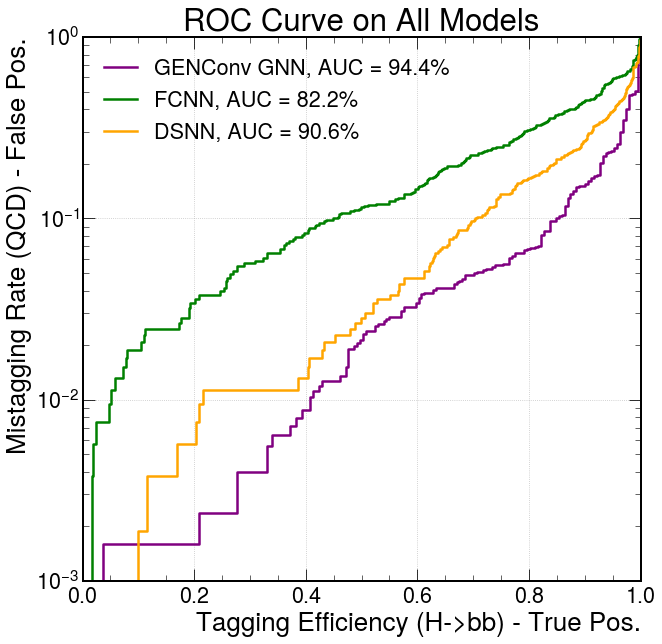

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
# create ROC curves
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(graph_predictions['hbb_label'], graph_predictions['hbb_sig'])
fpr_fcnn, tpr_fcnn, threshold_fcnn = roc_curve(fcnn_predictions['hbb_label'], fcnn_predictions['hbb_prediction'] )
fpr_dsnn, tpr_dsnn, threshold_dsnn = roc_curve(dsnn_predictions['hbb_label'], dsnn_predictions['hbb_prediction'])
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GENConv GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100), c = 'purple')
plt.plot(tpr_fcnn, fpr_fcnn, lw=2.5, label="FCNN, AUC = {:.1f}%".format(auc(fpr_fcnn,tpr_fcnn)*100), c = 'green')
plt.plot(tpr_dsnn, fpr_dsnn, lw=2.5, label="DSNN, AUC = {:.1f}%".format(auc(fpr_dsnn,tpr_dsnn)*100), c = 'orange')
plt.xlabel(r'Tagging Efficiency (H->bb) - True Pos.')
plt.ylabel(r'Mistagging Rate (QCD) - False Pos.')
plt.title('ROC Curve on All Models')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

### Graph of ROC using DDT (Designed Decorrelated Taggers) Procedure

In [16]:
sys.path.insert(0, os.path.realpath('../../config'))

In [17]:
sys.path

['/home/baambriz/q2_code/config',
 '/home/baambriz/q2_code/src/analysis',
 '/opt/conda/lib/python39.zip',
 '/opt/conda/lib/python3.9',
 '/opt/conda/lib/python3.9/lib-dynload',
 '',
 '/home/baambriz/.local/lib/python3.9/site-packages',
 '/opt/conda/lib/python3.9/site-packages',
 '/opt/conda/lib/python3.9/site-packages/IPython/extensions',
 '/home/baambriz/.ipython']

In [18]:
from utils import find_nearest

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

In [19]:
#DDT Procedure
cutoff = 0.01
idx_gnn, val_gnn = find_nearest(fpr_gnn, cutoff)
idx_fcnn, val_fcnn = find_nearest(fpr_fcnn, cutoff)
idx_dsnn, val_dsnn = find_nearest(fpr_dsnn, cutoff)
label_test_gnn_ddt = graph_predictions['hbb_label'] * (graph_predictions['hbb_sig'] > threshold_gnn[idx_gnn])
label_test_fcnn_ddt = fcnn_predictions['hbb_label'] * (fcnn_predictions['hbb_prediction'] > threshold_fcnn[idx_fcnn])
label_test_dsnn_ddt = dsnn_predictions['hbb_label'] * (dsnn_predictions['hbb_prediction'] > threshold_dsnn[idx_dsnn])

fpr_gnn_ddt, tpr_gnn_ddt, threshold_gnn_ddt = roc_curve(label_test_gnn_ddt, graph_predictions['hbb_prediction'])
fpr_fcnn_ddt, tpr_fcnn_ddt, threshold_fcnn_ddt = roc_curve(label_test_fcnn_ddt, fcnn_predictions['hbb_prediction'])
fpr_dsnn_ddt, tpr_dsnn_ddt, threshold_dsnn_ddt = roc_curve(label_test_dsnn_ddt, dsnn_predictions['hbb_prediction'])


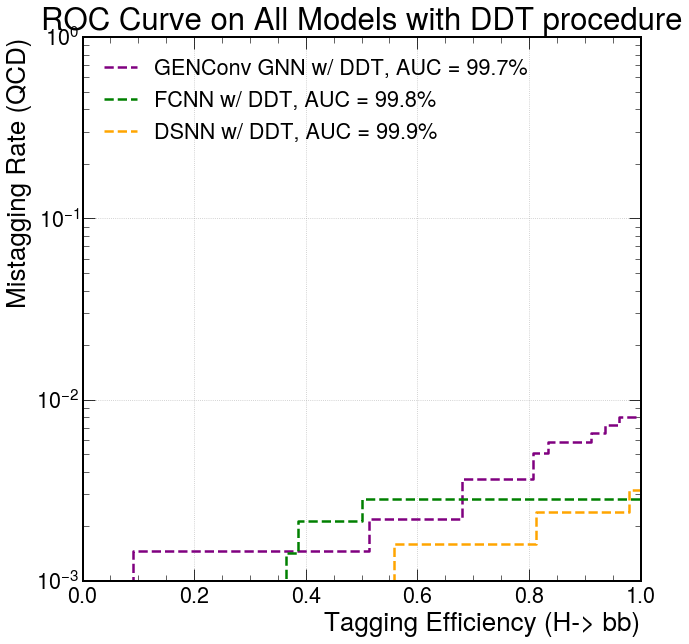

In [20]:
# plot curves
plt.figure()
plt.plot(tpr_gnn_ddt, fpr_gnn_ddt, color = 'purple', linestyle = '--', lw=2.5, label="GENConv GNN w/ DDT, AUC = {:.1f}%".format(auc(fpr_gnn_ddt, tpr_gnn_ddt)*100))
plt.plot(tpr_fcnn_ddt, fpr_fcnn_ddt, color = 'green', linestyle = '--', lw=2.5, label="FCNN w/ DDT, AUC = {:.1f}%".format(auc(fpr_fcnn_ddt, tpr_fcnn_ddt)*100))
plt.plot(tpr_dsnn_ddt, fpr_dsnn_ddt, color = 'orange', linestyle = '--', lw=2.5, label="DSNN w/ DDT, AUC = {:.1f}%".format(auc(fpr_dsnn_ddt, tpr_dsnn_ddt)*100))
plt.xlabel(r'Tagging Efficiency (H-> bb)')
plt.ylabel(r'Mistagging Rate (QCD)')
plt.title('ROC Curve on All Models with DDT procedure')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [21]:
import yaml

with open('../../config/definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

In [22]:
from DataGenerator import DataGenerator
# load testing file
test_files = ['~/teams/DSC180A_FA21_A00/a11/test/ntuple_merged_0.root']
test_generator = DataGenerator(test_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                               remove_mass_pt_window=True, 
                               return_spectators=True,
                               remove_unlabeled=True, max_entry = 4500)

In [23]:
from tqdm.notebook import tqdm

In [24]:
#collecting truth labels
spec_array_test = []
label_array_test = []
for t in tqdm(test_generator, total=len(test_generator)):
    spec_array_test.append(t[1][1])
    label_array_test.append(t[1])
label_array_test = np.concatenate(np.column_stack(label_array_test), axis=1)
spec_array_test = np.concatenate(spec_array_test, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
idx_gnn_ddt, val_gnn_ddt = find_nearest(fpr_gnn_ddt, cutoff)
idx_fcnn_ddt, val_fcnn_ddt = find_nearest(fpr_fcnn_ddt, cutoff)
idx_dsnn_ddt, val_dsnn_ddt = find_nearest(fpr_dsnn_ddt, cutoff)

In [26]:
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(graph_predictions['hbb_label'], graph_predictions['hbb_sig'])

(40.0, 200.0)

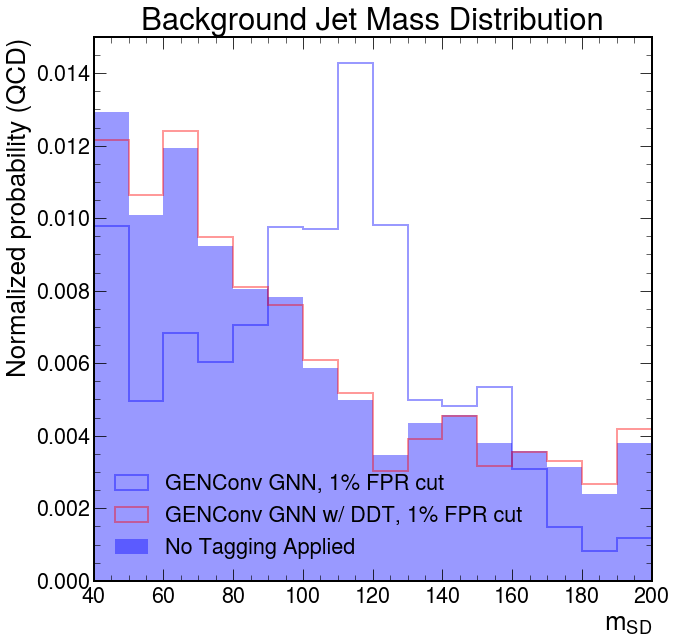

In [27]:
plt.figure()
for wp in [0.01]:
    plt.hist(spec_array_test[:,0], bins=np.linspace(20, 220, 21), 
             weights=graph_predictions['hbb_sig'],
             alpha=0.4, density=True, color = 'blue',label='GENConv GNN, {}% FPR cut'.format(int(wp*100)), histtype='step', linewidth = 2)
    plt.hist(spec_array_test[:, 0], bins=np.linspace(20, 220, 21), 
             weights= label_array_test[:, 0] * (graph_predictions['qcd_sig'] > threshold_gnn[idx_gnn]),
             alpha=0.4, density=True, color = 'red',label='GENConv GNN w/ DDT, {}% FPR cut'.format(int(wp*100)),histtype='step', linewidth = 2)
    plt.hist(spec_array_test[:,0], bins=np.linspace(20, 220, 21), 
             weights=label_array_test[:,0],
             alpha=0.4, density=True, color = 'blue', label='No Tagging Applied'.format(int(wp*100)))
    plt.title("Background Jet Mass Distribution")
plt.legend(loc='lower left')
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability (QCD)')
plt.xlim(40, 200)

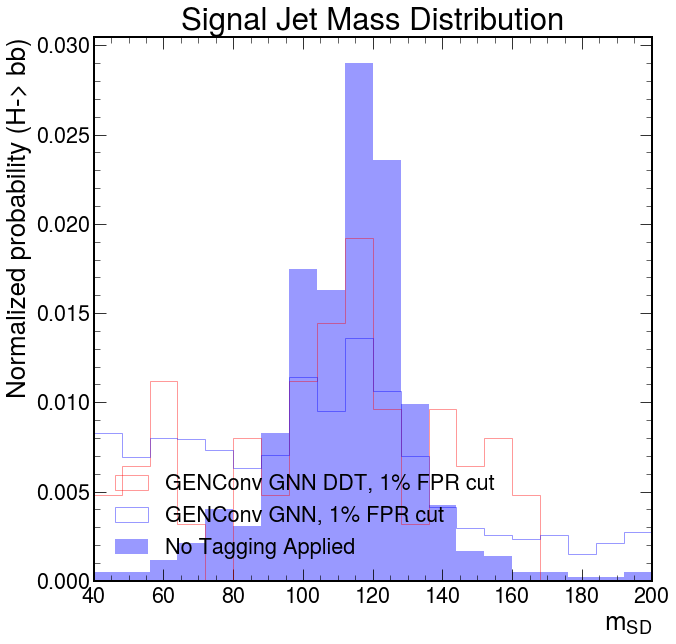

In [28]:
plt.figure()
for wp in [0.01]:
    idx, val = find_nearest(fpr_gnn, wp)
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights=label_test_gnn_ddt,
             alpha=0.4, density=True, color='red', label='GENConv GNN DDT, {}% FPR cut'.format(int(wp*100)),histtype='step')
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights=graph_predictions['qcd_sig'],
             alpha=0.4, density=True, color = 'blue',label='GENConv GNN, {}% FPR cut'.format(int(wp*100)), histtype='step')
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights=label_array_test[:,1],
             alpha=0.4, density=True, color = 'blue', label='No Tagging Applied'.format(int(wp*100)))
    plt.title("Signal Jet Mass Distribution")
plt.legend(loc='lower left')
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability (H-> bb)')
plt.xlim(40, 200)
plt.show()